# Build a regional domain MOM6 model with identical resolution to the parent model 


This example will focus on a domain centered in the Gulf of Mexico. 

Grid locations and metrics, bathymetry, initial and boundary conditions will be extracted  from the global (parent) model. 

Out files are to be used in a regional version of the model after a few modifications to the global configuration

In [4]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os
import subprocess

 Path to supergrid file containing grid locations and metrics, and topography file. Note that I am using the ocean_static file which is output from the parent run, rather than the topog.nc input file , due to the general case where online edits are made to the bathymetry 

In [85]:
path_sg='parent_grid/c192_mosaic/ocean_hgrid.nc'
path_topo_input='parent_grid/ocean_static.nc'
path_basin_in='parent_grid/basin_codes.nc'
#path_topo='20120101.ocean_static.nc'

First extract the tracer cell centroids, which will be used to identify the desired rectangular domain

In [86]:
sg=nc.Dataset(path_sg)
X=sg.variables['x'][1::2,1::2]
Y=sg.variables['y'][1::2,1::2]


In [87]:
region_name='NWAtl'
path_out=region_name
if not os.path.isdir(path_out): os.mkdir(path_out)

Step 1. Select the bounding latitudes and longitudes for the regional domain model

In [88]:
lat_s=15;lat_n=54;lon_w=-100.;lon_e=-58.

In [89]:
x=sg.variables['x'][:]
y=sg.variables['y'][:]
jstart_sg=np.where(y>=lat_s)[0][0]
if np.mod(jstart_sg,2)==1: jstart_sg=jstart_sg-1
jend_sg=np.where(y>=lat_n)[0][0]
if np.mod(jend_sg,2)==1: jend_sg=jend_sg+1
istart_sg=np.where(x[jstart_sg,:]>=lon_w)[0][0]
if np.mod(istart_sg,2)==1: istart_sg=istart_sg-1
iend_sg=np.where(x[jstart_sg,:]>=lon_e)[0][0]
if np.mod(iend_sg,2)==1: iend_sg=iend_sg+1
print('supergrid indices=',istart_sg,iend_sg,jstart_sg,jend_sg)
istart=istart_sg//2;iend=(iend_sg-1)//2
jstart=jstart_sg//2;jend=(jend_sg-1)//2
print('grid indices=',istart,iend,jstart,jend)


supergrid indices= 1600 1936 1130 1524
grid indices= 800 967 565 761


Text(0.5, 1.0, 'Regional Domain Bathymetry')

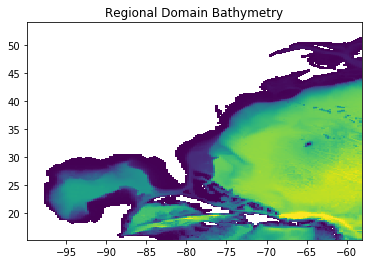

In [91]:
topo_=nc.Dataset(path_topo_input).variables['deptho'][jstart:jend+1,istart:iend+1]
basin_=nc.Dataset(path_basin_in).variables['basin'][jstart:jend+1,istart:iend+1]

x_=X[jstart:jend+1,istart:iend+1]
y_=Y[jstart:jend+1,istart:iend+1]

basin_[basin_==2]=1
basin_[basin_==4]=1
basin_[basin_==6]=1
#basin_[basin_==7]=1
#basin_[basin_==8]=1
#basin_[basin_==9]=1
basin_[basin_!=1]=0

topo_=np.ma.masked_where(basin_==0.,topo_*basin_)

plt.pcolormesh(x_,y_,topo_)
#plt.pcolormesh(x_,y_,basin_)

plt.title('Regional Domain Bathymetry')

Step 2. Use NCO tools to extract the regional domain from existing restarts

Note: This step can be a bit tricky because the MOM6 restart file is separated into 4 individual files due to the large size of the parent model. Fields located in the tracer cell faces are larger by one in the x-direction for C-grid u fields and in the y-direction for v fields.  This code assumes that the parent model was run in symmetric mode, so that the history and restart files have the additional values. I have not tested this in the case where the parent model is run in non-symmetric mode (regional configurations only work in symmetric mode)

In [30]:
restart_path='/parent_restart/RESTART/MOM.res.nc'
cmdline='ncks -O  -d lonh,'+str(istart)+','+str(iend)+' -d lath,'+str(jstart)+','+str(jend)+\
         ' -d lonq,'+str(istart)+','+str(iend+1)+\
         ' '+restart_path+' '+path_out+'/MOM.res.nc'
print(cmdline)
subprocess.run(cmdline,shell=True,stdout=subprocess.PIPE)

restart_path='/parent_restart/RESTART/MOM.res_1.nc'
cmdline='ncks -O -d lonh,'+str(istart)+','+str(iend)+' -d lath,'+str(jstart)+','+str(jend)+\
         ' -d lonq,'+str(istart)+','+str(iend+1)+' -d latq,'+str(jstart)+','+str(jend+1)+\
         ' '+restart_path+' '+path_out+'/MOM.res_1.nc'
subprocess.run(cmdline,shell=True,stdout=subprocess.PIPE)
restart_path='/parent_restart/RESTART/MOM.res_2.nc'
cmdline='ncks -O -d lonh,'+str(istart)+','+str(iend)+' -d lath,'+str(jstart)+','+str(jend)+\
         ' -d lonq,'+str(istart)+','+str(iend+1)+' -d latq,'+str(jstart)+','+str(jend+1)+\
         ' '+restart_path+' '+path_out+'/MOM.res_2.nc'
subprocess.run(cmdline,shell=True,stdout=subprocess.PIPE)

restart_path='/parent_restart/RESTART/MOM.res_3.nc'
cmdline='ncks -O -d lonh,'+str(istart)+','+str(iend)+' -d lath,'+str(jstart)+','+str(jend)+\
         ' '+restart_path+' '+path_out+'/MOM.res_3.nc'

subprocess.run(cmdline,shell=True,stdout=subprocess.PIPE)
restart_path='/parent_restart/RESTART/MOM.res_4.nc'
cmdline='ncks -O -d lonh,'+str(istart)+','+str(iend)+' -d lath,'+str(jstart)+','+str(jend)+\
         ' '+restart_path+' '+path_out+'/MOM.res_4.nc'
subprocess.run(cmdline,shell=True,stdout=subprocess.PIPE)
restart_path='/parent_restart/RESTART/ice_model.res.nc'
cmdline='ncks -O -d lonh,'+str(istart)+','+str(iend)+' -d lath,'+str(jstart)+','+str(jend)+\
         ' -d lonh,'+str(istart)+','+str(iend+1)+' -d lath,'+str(jstart)+','+str(jend+1)+\
         ' '+restart_path+' '+path_out+'/ice_model.res.nc'
subprocess.run(cmdline,shell=True,stdout=subprocess.PIPE)


ncks -O  -d lonh,800,967 -d lath,565,761 -d lonq,800,968 /parent_restart/RESTART/MOM.res.nc NWAtl/MOM.res.nc


CompletedProcess(args='ncks -O -d lonh,800,967 -d lath,565,761 -d lonh,800,968 -d lath,565,762 /parent_restart/RESTART/ice_model.res.nc NWAtl/ice_model.res.nc', returncode=0, stdout=b'')

In [32]:
f_topo=nc.Dataset(path_out+'/topog.nc','w',format='NETCDF3_CLASSIC')
ny,nx=topo_.shape
f_topo.createDimension('ny',ny)
f_topo.createDimension('nx',nx)
f_topo.createDimension('ntiles',1)
f_topo.createVariable('depth','f8',('ny','nx'))
f_topo.createVariable('h2','f8',('ny','nx'))
topo_=np.ma.filled(topo_,0.)
f_topo.variables['depth'][:]=topo_
path_topo2 = 'parent_grid/c192_mosaic/topog.nc'
# H2 is a topographic roughness parameter which is used for tidal parameterizations. 
h2_=nc.Dataset(path_topo2).variables['h2'][jstart:jend+1,istart:iend+1]
f_topo.variables['h2'][:]=h2_
f_topo.sync()
f_topo.close()

In [33]:
f_sg=nc.Dataset(path_out+'/ocean_hgrid.nc','w',format='NETCDF3_CLASSIC')
f_sg.createDimension('ny',ny*2)
f_sg.createDimension('nx',nx*2)
f_sg.createDimension('nyp',ny*2+1)
f_sg.createDimension('nxp',nx*2+1)
f_sg.createDimension('string',255)
f_sg.createVariable('y','f8',('nyp','nxp'))
f_sg.createVariable('x','f8',('nyp','nxp'))
f_sg.createVariable('dy','f8',('ny','nxp'))
f_sg.createVariable('dx','f8',('nyp','nx'))
f_sg.createVariable('area','f8',('ny','nx'))
f_sg.createVariable('angle_dx','f8',('nyp','nxp'))
f_sg.createVariable('tile','S1',('string'))
f_sg.variables['y'].units='degrees'
f_sg.variables['x'].units='degrees'
f_sg.variables['dy'].units='meters'
f_sg.variables['dx'].units='meters'
f_sg.variables['area'].units='m2'
f_sg.variables['angle_dx'].units='degrees'
f_sg.variables['y'][:]=sg.variables['y'][jstart_sg:jend_sg+1,istart_sg:iend_sg+1]
f_sg.variables['x'][:]=sg.variables['x'][jstart_sg:jend_sg+1,istart_sg:iend_sg+1]
f_sg.variables['dx'][:]=sg.variables['dx'][jstart_sg:jend_sg+1,istart_sg:iend_sg]
f_sg.variables['dy'][:]=sg.variables['dy'][jstart_sg:jend_sg,istart_sg:iend_sg+1]
f_sg.variables['area'][:]=sg.variables['area'][jstart_sg:jend_sg,istart_sg:iend_sg]
f_sg.variables['angle_dx'][:]=sg.variables['angle_dx'][jstart_sg:jend_sg+1,istart_sg:iend_sg+1]
f_sg.variables['tile'][0] = 't'  ## This is stupid
f_sg.variables['tile'][1] = 'i'
f_sg.variables['tile'][2] = 'l'
f_sg.variables['tile'][3] = 'e'
f_sg.variables['tile'][4] = '1'
f_sg.sync()
f_sg.close()

Step 7. Write regional mosaic information for use by FMS coupling framework

In [34]:
dx=sg.variables['dx'][jstart_sg:jend_sg+1,istart_sg:iend_sg]
dy=sg.variables['dy'][jstart_sg:jend_sg,istart_sg:iend_sg+1]
d2x=dx+np.roll(dx,shift=-1,axis=1)
d2x=d2x[:,::2]
DX=0.5*(d2x+np.roll(d2x,shift=-1,axis=0))
DX=DX[:-1:2,:]
d2y=dy+np.roll(dy,shift=-1,axis=0)
d2y=d2y[::2,:]
DY=0.5*(d2y+np.roll(d2y,shift=-1,axis=1))
DY=DY[:,:-1:2]
AREA=DX*DY

In [35]:
name = path_out+'/ocean_mosaic'
rg = nc.Dataset(name+'.nc','w')
rg.createDimension('ntiles',1)
rg.createDimension('string',255)
mosaic = rg.createVariable('mosaic','c',('string',))
mosaic.standard_name = 'grid_mosaic_spec'
mosaic.children = 'contacts'
mosaic.grid_descriptor = ''
gridlocation = rg.createVariable('gridlocation','c',('string',))
gridlocation.standard_name = 'grid_file_location'
gridfiles = rg.createVariable('gridfiles','c',('ntiles','string',))
gridtiles = rg.createVariable('gridtiles','c',('ntiles','string',))
rg.grid_version = '0.2'
# Fill in data                                                                                                                                                                                                     
mosaic[:] = '\000' * 255
mosaic[:12] = 'ocean_mosaic'
gridlocation[:] = '\000' * 255
gridlocation[:2] = './'
gridfiles[:] = '\000' * 255
gridfiles[0,:14] = 'ocean_hgrid.nc'
gridtiles[:] = '\000' * 255
gridtiles[0,:5] = 'tile1'
rg.close()


In [36]:
nl=len(np.where(topo_==0.)[0])
print('NL=',nl)
rg = nc.Dataset(path_out+'/atmos_mosaic_tile1Xland_mosaic_tile1.nc','w',format='NETCDF3_CLASSIC') # atmos_mosaic_tile1Xland_mosaic_tile1.nc                                                                                  
rg2 = nc.Dataset(path_out+'/land_mask.nc','w',format='NETCDF3_CLASSIC') # atmos_mosaic_tile1Xland_mosaic_tile1.nc                                                                                                            
rg.createDimension('string',255)
rg.createDimension('ncells',nl)  #It is unclear whether this works when nl=0. It does work for nl>0                                                                                                                
rg.createDimension('two',2)
contact = rg.createVariable('contact','c',('string',))
contact.standard_name = 'grid_contact_spec'
contact.contact_type = 'exchange'
contact.parent1_cell = 'tile1_cell'
contact.parent2_cell = 'tile2_cell'
contact.xgrid_area_field = 'xgrid_area'
contact.distant_to_parent1_centroid = 'tile1_distance'
contact.distant_to_parent2_centroid = 'tile2_distance'
tile1_cell = rg.createVariable('tile1_cell','i4',('ncells','two',))
tile1_cell.standard_name = 'parent_cell_indices_in_mosaic1'
tile2_cell = rg.createVariable('tile2_cell','i4',('ncells','two',))
tile2_cell.standard_name = 'parent_cell_indices_in_mosaic2'
xgrid_area = rg.createVariable('xgrid_area','f8',('ncells',))
xgrid_area.standard_name = 'exchange_grid_area'
xgrid_area.units = 'm2'
tile1_distance = rg.createVariable('tile1_distance','f8',('ncells','two'))
tile1_distance.standard_name = 'distance_from_parent1_cell_centroid'
tile2_distance = rg.createVariable('tile2_distance','f8',('ncells','two'))
tile2_distance.standard_name = 'distance_from_parent2_cell_centroid'
rg.grid_version = '0.2'

rg2.createDimension('nx',nx)
rg2.createDimension('ny',ny)
mask=rg2.createVariable('mask','f8',('ny','nx'))
mask.standard_name  = 'land fraction at T-cell centers'
mask.units = 'none'
mask[:,:]=0.0
rg2.grid_version = '0.2'

contact[:] = '\000' * 255
contact[:37] = 'atmos_mosaic:tile1::land_mosaic:tile1'
count=0
for j in range(ny):
    for i in range(nx):
        if topo_[j,i]==0.:
            tile1_cell[count] = [i+1,j+1]
            tile2_cell[count] = [i+1,j+1]
            tile1_distance[count] = [0.,0.]
            tile2_distance[count] = [0.,0.]
            xgrid_area[count] = AREA[j,i]
            count=count+1
            mask[j,i]=1.0
rg.close()
rg2.close()

NL= 18236


In [37]:
rg = nc.Dataset(path_out+'/atmos_mosaic_tile1Xocean_mosaic_tile1.nc','w',format='NETCDF3_CLASSIC') # atmos_mosaic_tile1Xocean_mosaic_tile1.nc                                                                                
rg2 = nc.Dataset(path_out+'/ocean_mask.nc','w',format='NETCDF3_CLASSIC') # atmos_mosaic_tile1Xland_mosaic_tile1.nc                                                                                                           
rg.createDimension('string',255)
rg.createDimension('ncells',nx*ny-nl) # -1 is for a single land point                                                                                                                                              
print('ncells= ',nx*ny-nl)
rg.createDimension('two',2)
contact = rg.createVariable('contact','c',('string',))
contact.standard_name = 'grid_contact_spec'
contact.contact_type = 'exchange'
contact.parent1_cell = 'tile1_cell'
contact.parent2_cell = 'tile2_cell'
contact.xgrid_area_field = 'xgrid_area'
contact.distant_to_parent1_centroid = 'tile1_distance'
contact.distant_to_parent2_centroid = 'tile2_distance'
tile1_cell = rg.createVariable('tile1_cell','i4',('ncells','two',))
tile1_cell.standard_name = 'parent_cell_indices_in_mosaic1'
tile2_cell = rg.createVariable('tile2_cell','i4',('ncells','two',))
tile2_cell.standard_name = 'parent_cell_indices_in_mosaic2'
xgrid_area = rg.createVariable('xgrid_area','f8',('ncells',))
xgrid_area.standard_name = 'exchange_grid_area'
xgrid_area.units = 'm2'
tile1_distance = rg.createVariable('tile1_distance','f8',('ncells','two'))
tile1_distance.standard_name = 'distance_from_parent1_cell_centroid'
tile2_distance = rg.createVariable('tile2_distance','f8',('ncells','two'))
tile2_distance.standard_name = 'distance_from_parent2_cell_centroid'
rg.grid_version = '0.2'
# Fill in data                                                                                                                                                                                                     
contact[:] = '\000' * 255
contact[:38] = 'atmos_mosaic:tile1::ocean_mosaic:tile1'

rg2.createDimension('nx',nx)
rg2.createDimension('ny',ny)
mask=rg2.createVariable('mask','f8',('ny','nx'))
mask.standard_name  = 'ocean fraction at T-cell centers'
mask.units = 'none'
mask[:,:]=0.0
rg2.grid_version = '0.2'

count=0
for j in range(ny):
    for i in range(nx):
        if topo_[j,i]!=0:
            tile1_cell[count] = [i+1,j+1]
            tile2_cell[count] = [i+1,j+1]
            tile1_distance[count] = [0.,0.]
            tile2_distance[count] = [0.,0.]
            xgrid_area[count] = AREA[j,i]
            count=count+1
            mask[j,i]=1.0
rg.close()
rg2.close()

ncells=  14860


In [38]:
rg = nc.Dataset(path_out+'/land_mosaic_tile1Xocean_mosaic_tile1.nc','w',format='NETCDF3_CLASSIC') # land_mosaic_tile1Xocean_mosaic_tile1.nc                                                                                  
rg.createDimension('string',255)
rg.createDimension('ncells',nx*ny-nl) # -1 is for a single land point                                                                                                                                              
rg.createDimension('two',2)
contact = rg.createVariable('contact','c',('string',))
contact.standard_name = 'grid_contact_spec'
contact.contact_type = 'exchange'
contact.parent1_cell = 'tile1_cell'
contact.parent2_cell = 'tile2_cell'
contact.xgrid_area_field = 'in:sent xgrid_area'
contact.distant_to_parent1_centroid = 'tile1_distance'
contact.distant_to_parent2_centroid = 'tile2_distance'
tile1_cell = rg.createVariable('tile1_cell','i4',('ncells','two',))
tile1_cell.standard_name = 'parent_cell_indices_in_mosaic1'
tile2_cell = rg.createVariable('tile2_cell','i4',('ncells','two',))
tile2_cell.standard_name = 'parent_cell_indices_in_mosaic2'
xgrid_area = rg.createVariable('xgrid_area','f8',('ncells',))
xgrid_area.standard_name = 'exchange_grid_area'
xgrid_area.units = 'm2'
tile1_distance = rg.createVariable('tile1_distance','f8',('ncells','two'))
tile1_distance.standard_name = 'distance_from_parent1_cell_centroid'
tile2_distance = rg.createVariable('tile2_distance','f8',('ncells','two'))
tile2_distance.standard_name = 'distance_from_parent2_cell_centroid'
rg.grid_version = '0.2'
# Fill in data                                                                                                                                                                                                     
contact[:] = '\000' * 255
contact[:37] = 'land_mosaic:tile1::ocean_mosaic:tile1'
count=0
for j in range(ny):
    for i in range(nx):
        if topo_[j,i]>0.:
            tile1_cell[count] = [i+1,j+1]
            tile2_cell[count] = [i+1,j+1]
            tile1_distance[count] = [0.,0.]
            tile2_distance[count] = [0.,0.]
            xgrid_area[count] = AREA[j,i]
            count=count+1


rg.close()


In [40]:
rg = nc.Dataset(path_out+'/grid_spec.nc','w',format='NETCDF3_CLASSIC') # land_mosaic_tile1Xocean_mosaic_tile1.nc                                                                                                              
rg.createDimension('string',255)
rg.createDimension('nfile_aXo',1) # -1 is for a single land point                                                                                                                                                  
rg.createDimension('nfile_aXl',1) # -1 is for a single land point                                                                                                                                                  
rg.createDimension('nfile_lXo',1) # -1 is for a single land point                                                                                                                                                  
atm_mosaic_dir = rg.createVariable('atm_mosaic_dir','c',('string',))
atm_mosaic_dir.standard_name = 'directory_storing_atmosphere_mosaic'
atm_mosaic_file = rg.createVariable('atm_mosaic_file','c',('string',))
atm_mosaic_file.standard_name = 'atmosphere_mosaic_file_name'
atm_mosaic = rg.createVariable('atm_mosaic','c',('string',))
atm_mosaic.standard_name = 'atmosphere_mosaic_name'
lnd_mosaic_dir = rg.createVariable('lnd_mosaic_dir','c',('string',))
lnd_mosaic_dir.standard_name = 'directory_storing_land_mosaic'
lnd_mosaic_file = rg.createVariable('lnd_mosaic_file','c',('string',))
lnd_mosaic_file.standard_name = 'land_mosaic_file_name'
lnd_mosaic = rg.createVariable('lnd_mosaic','c',('string',))
lnd_mosaic.standard_name = 'land_mosaic_name'
ocn_mosaic_dir = rg.createVariable('ocn_mosaic_dir','c',('string',))
ocn_mosaic_dir.standard_name = 'directory_storing_ocean_mosaic'
ocn_mosaic_file = rg.createVariable('ocn_mosaic_file','c',('string',))
ocn_mosaic_file.standard_name = 'ocean_mosaic_file_name'
ocn_mosaic = rg.createVariable('ocn_mosaic','c',('string',))
ocn_mosaic.standard_name = 'ocean_mosaic_name'
ocn_topog_dir = rg.createVariable('ocn_topog_dir','c',('string',))
ocn_mosaic_dir.standard_name = 'directory_storing_ocean_topog'
ocn_topog_file = rg.createVariable('ocn_topog_file','c',('string',))
ocn_topog_file.standard_name = 'ocean_topog_file_name'
aXo_file = rg.createVariable('aXo_file','c',('nfile_aXo','string',))
aXo_file.standard_name = 'atmXocn_exchange_grid_file'
aXl_file = rg.createVariable('aXl_file','c',('nfile_aXl','string',))
aXl_file.standard_name = 'atmXlnd_exchange_grid_file'
lXo_file = rg.createVariable('lXo_file','c',('nfile_lXo','string',))
lXo_file.standard_name = 'lndXocn_exchange_grid_file'
#Global attributes                                                                                                                                                                                                 
rg.grid_version = '0.2'
rg.code_version = "$Name:  $"
rg.history = " "

atm_mosaic_dir[:] = '\000' * 255
atm_mosaic_dir[:2] = './'
atm_mosaic_file[:] = '\000' * 255
atm_mosaic_file[:15] = 'ocean_mosaic.nc'
atm_mosaic[:] = '\000' * 255
atm_mosaic[:12] = 'atmos_mosaic'
lnd_mosaic_dir[:] = '\000' * 255
lnd_mosaic_dir[:2] = './'
lnd_mosaic_file[:] = '\000' * 255
lnd_mosaic_file[:15] = 'ocean_mosaic.nc'
lnd_mosaic[:] = '\000' * 255
lnd_mosaic[:11] = 'land_mosaic'
ocn_mosaic_dir[:] = '\000' * 255
ocn_mosaic_dir[:2] = './'
ocn_mosaic_file[:] = '\000' * 255
ocn_mosaic_file[:15] = 'ocean_mosaic.nc'
ocn_mosaic[:] = '\000' * 255
ocn_mosaic[:12] = 'ocean_mosaic'
ocn_topog_dir[:] = '\000' * 255
ocn_topog_dir[:2] = './'
ocn_topog_file[:] = '\000' * 255
ocn_topog_file[:8] = 'topog.nc'
aXo_file[:,:] = '\000' * 255
aXo_file[:,:40] = 'atmos_mosaic_tile1Xocean_mosaic_tile1.nc'
aXl_file[:,:] = '\000' * 255
aXl_file[:,:39] = 'atmos_mosaic_tile1Xland_mosaic_tile1.nc'
lXo_file[:,:] = '\000' * 255
lXo_file[:,:39] = 'land_mosaic_tile1Xocean_mosaic_tile1.nc'

rg.close()

In [92]:
nj,ni = topo_.shape
print('The model size= ',nj,ni)

The model size=  197 168


In [93]:
path_parent_data='parent_data/19920101.ocean_NWA.nc'
g=nc.Dataset(path_parent_data)
xu=g.variables['xq_sub01'][:]
yv=g.variables['yq_sub01'][:]
jstart=np.where(yv>=lat_s)[0][0]
jend=np.where(yv>=lat_n)[0][0]-1
istart=np.where(xu>=lon_w)[0][0]
iend=np.where(xu>=lon_e)[0][0]-1
print('parent data size= ',xu.shape[0]-1,yv.shape[0]-1)
print('grid indices=',istart,iend,jstart,jend)


parent data size=  176 224
grid indices= 0 167 13 209


In [60]:
path_hist_month='data/19920101.ocean_month.nc'
cmdline='ncks -O  -v temp,salt,u,v,ssh -d xh_sub01,'+str(istart)+','+str(iend)+\
         ' -d yh_sub01,'+str(jstart)+','+str(jend)+\
         ' -d xq_sub01,'+str(istart)+','+str(iend+1)+' -d yq_sub01,'+str(jstart)+','+str(jend+1)+\
         ' -d xh_sub02,'+str(istart)+','+str(iend)+\
         ' -d yh_sub02,'+str(jstart)+','+str(jend)+\
         ' '+path_parent_data+' '+path_out+'/parent_state.nc'
print(cmdline)
subprocess.run(cmdline,shell=True,stdout=subprocess.PIPE)


ncks -O  -v temp,salt,u,v,ssh -d xh_sub01,0,167 -d yh_sub01,13,209 -d xq_sub01,0,168 -d yq_sub01,13,210 -d xh_sub02,0,167 -d yh_sub02,13,209 parent_data/19920101.ocean_NWA.nc NWAtl/parent_state.nc


CompletedProcess(args='ncks -O  -v temp,salt,u,v,ssh -d xh_sub01,0,167 -d yh_sub01,13,209 -d xq_sub01,0,168 -d yq_sub01,13,210 -d xh_sub02,0,167 -d yh_sub02,13,209 parent_data/19920101.ocean_NWA.nc NWAtl/parent_state.nc', returncode=0, stdout=b'')

In [72]:
wet=np.zeros(topo_.shape)
wet[topo_>0.]=1.


In [73]:
f=nc.Dataset(path_out+'/parent_state.nc','a')

ssh=f.variables['ssh'][:].filled(0.)
f.variables['ssh'][:]=ssh
del(ssh)
u=f.variables['u'][:].filled(0.)
f.variables['u'][:]=u
del(u)
v=f.variables['v'][:].filled(0.)
f.variables['v'][:]=v
del(v)
temp=f.variables['temp'][:].filled(0.)
f.variables['temp'][:]=temp
del(temp)
salt=f.variables['salt'][:].filled(0.)
f.variables['salt'][:]=salt
del(salt)


In [74]:
f.sync()
f.close()

In [105]:
dampTime = 20.0     # days
secDays = 8.64e4
fl = nc.Dataset('sponge.nc', 'w', format='NETCDF3_CLASSIC')
fl.createDimension('lon', nx)
fl.createDimension('lat', ny)
lonv = fl.createVariable('lon', 'f8', ('lon'))
latv = fl.createVariable('lat', 'f8', ('lat'))
spv = fl.createVariable('Idamp', 'f8', ('lat', 'lon'), fill_value=-1.e20)
Idamp = np.zeros((ny, nx))
Ywidth=5. # degrees
pi_2 = np.pi/2.
if dampTime > 0.:
    lats=y_[0,0];latn=y_[-1,0]
    fcns=np.cos(pi_2*np.minimum(y_-lats,Ywidth)/Ywidth)
    fcn=fcns+np.cos(pi_2*np.minimum(latn-y_,Ywidth)/Ywidth)
    Idamp = 0.0 + fcn / (dampTime * secDays)
spv[:] = Idamp
lonv[:] = x_[0, :]
latv[:] = y_[:, 0]
fl.sync()
fl.close()


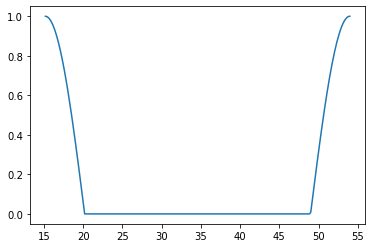

In [104]:
plt.plot(y_[:,0],fcn[:,0])

In [84]:
y_.max()

-29.480836650827474